In [ ]:
# Runtime check
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))


PyTorch version: 2.9.0+cu126
CUDA available: True
Device: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q timm faiss-cpu umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.0 MB/s eta 0:00:00


In [ ]:
import os, json, numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ROOT = '/content/image_similarity_project/tiny-imagenet-200'
DRIVE_OUT = '/content/drive/MyDrive/image_similarity_project'   # ensure folder exists in Drive
os.makedirs(DRIVE_OUT, exist_ok=True)
print("ROOT:", ROOT, "DRIVE_OUT:", DRIVE_OUT)


ROOT: /content/image_similarity_project/tiny-imagenet-200 DRIVE_OUT: /content/drive/MyDrive/image_similarity_project


In [ ]:
import os, json, numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ROOT = '/content/image_similarity_project/tiny-imagenet-200'
DRIVE_OUT = '/content/drive/MyDrive/image_similarity_project'   # ensure folder exists in Drive
os.makedirs(DRIVE_OUT, exist_ok=True)
print("ROOT:", ROOT, "DRIVE_OUT:", DRIVE_OUT)


ROOT: /content/image_similarity_project/tiny-imagenet-200 DRIVE_OUT: /content/drive/MyDrive/image_similarity_project


In [ ]:
# Create project folder
!mkdir -p /content/image_similarity_project
%cd /content/image_similarity_project

# Copy your ZIP from Drive into Colab
!cp "/content/drive/MyDrive/archive (8).zip" "./tiny_imagenet.zip"

# Unzip
!unzip -q "tiny_imagenet.zip"

/content/image_similarity_project


In [ ]:
!ls -R /content/image_similarity_project


Streaming output truncated to the last 5000 lines.
n06596364_208.JPEG  n06596364_320.JPEG	n06596364_433.JPEG  n06596364_96.JPEG
n06596364_209.JPEG  n06596364_321.JPEG	n06596364_434.JPEG  n06596364_97.JPEG
n06596364_20.JPEG   n06596364_322.JPEG	n06596364_435.JPEG  n06596364_98.JPEG
n06596364_210.JPEG  n06596364_323.JPEG	n06596364_436.JPEG  n06596364_99.JPEG
n06596364_211.JPEG  n06596364_324.JPEG	n06596364_437.JPEG  n06596364_9.JPEG

/content/image_similarity_project/tiny-imagenet-200/train/n07579787:
images	n07579787_boxes.txt

/content/image_similarity_project/tiny-imagenet-200/train/n07579787/images:
n07579787_0.JPEG    n07579787_212.JPEG	n07579787_325.JPEG  n07579787_438.JPEG
n07579787_100.JPEG  n07579787_213.JPEG	n07579787_326.JPEG  n07579787_439.JPEG
n07579787_101.JPEG  n07579787_214.JPEG	n07579787_327.JPEG  n07579787_43.JPEG
n07579787_102.JPEG  n07579787_215.JPEG	n07579787_328.JPEG  n07579787_440.JPEG
n07579787_103.JPEG  n07579787_216.JPEG	n07579787_329.JPEG  n07579787_441.JPEG
n0

In [ ]:
# transforms
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(os.path.join(ROOT,'train'), transform=train_tf)
val_ds = datasets.ImageFolder(os.path.join(ROOT,'val'), transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))
# save mapping for visualization
val_paths = [p[0] for p in val_ds.samples]
with open('val_paths.json','w') as f:
    json.dump(val_paths, f)
!cp val_paths.json "{DRIVE_OUT}/"


Train samples: 100000 Val samples: 10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import os, shutil

root = "/content/image_similarity_project/tiny-imagenet-200/train"

for cls in os.listdir(root):
    cls_path = os.path.join(root, cls)
    images_path = os.path.join(cls_path, "images")

    if os.path.isdir(images_path):
        # Move all images up one level
        for fname in os.listdir(images_path):
            src = os.path.join(images_path, fname)
            dst = os.path.join(cls_path, fname)
            shutil.move(src, dst)
        # Remove the now-empty images folder
        os.rmdir(images_path)

print("Train folder fixed ✔")


Train folder fixed ✔


In [ ]:
import os, shutil

root_val = "/content/image_similarity_project/tiny-imagenet-200/val"
images_path = os.path.join(root_val, "images")
ann_file = os.path.join(root_val, "val_annotations.txt")

# Only run this if the val folder still has images/ inside it
if os.path.exists(images_path):
    print("Organizing validation images...")
    with open(ann_file, "r") as f:
        for line in f:
            fname, cls = line.split("\t")[:2]
            cls_path = os.path.join(root_val, cls)
            os.makedirs(cls_path, exist_ok=True)
            shutil.move(os.path.join(images_path, fname), os.path.join(cls_path, fname))

    os.rmdir(images_path)

print("Val folder fixed ✔")


Organizing validation images...
Val folder fixed ✔


In [ ]:
!ls -R /content/image_similarity_project/tiny-imagenet-200/train | head


/content/image_similarity_project/tiny-imagenet-200/train:
n01443537
n01629819
n01641577
n01644900
n01698640
n01742172
n01768244
n01770393
n01774384


In [ ]:
!ls -R /content/image_similarity_project/tiny-imagenet-200/val | head


/content/image_similarity_project/tiny-imagenet-200/val:
n01443537
n01629819
n01641577
n01644900
n01698640
n01742172
n01768244
n01770393
n01774384


In [ ]:
!ls /content/image_similarity_project/tiny-imagenet-200/train | head

n01443537
n01629819
n01641577
n01644900
n01698640
n01742172
n01768244
n01770393
n01774384
n01774750


In [ ]:
ROOT = "/content/image_similarity_project/tiny-imagenet-200"

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(f"{ROOT}/train", transform=train_tf)
val_ds   = datasets.ImageFolder(f"{ROOT}/val", transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))


Train samples: 100000 Val samples: 10000


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DRIVE_OUT = "/content/drive/MyDrive/image_similarity_project"
import os
os.makedirs(DRIVE_OUT, exist_ok=True)
print("Drive mounted. Outputs ->", DRIVE_OUT)


Mounted at /content/drive
Drive mounted. Outputs -> /content/drive/MyDrive/image_similarity_project


In [ ]:
import os, numpy as np, torch
from torchvision import models
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device, torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

ROOT = "/content/image_similarity_project/tiny-imagenet-200"
TRAIN_FOLDER = os.path.join(ROOT, "train")
VAL_FOLDER   = os.path.join(ROOT, "val")
OUT_DIR = "/content"   # local session out (will copy to Drive)
DRIVE_OUT = "/content/drive/MyDrive/image_similarity_project"

BATCH_SAVE_EVERY = 200   # save to disk every N batches (tweak if you want)


Device: cuda Tesla T4


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# transforms (use same as before)
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# For extraction we only need eval transforms (no augment)
train_ds = datasets.ImageFolder(TRAIN_FOLDER, transform=eval_tf)
val_ds   = datasets.ImageFolder(VAL_FOLDER, transform=eval_tf)

batch_size = 64   # if OOM reduce to 32 or 16
num_workers = 4

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))


Train samples: 100000 Val samples: 10000


In [ ]:
import torch.nn as nn
backbone = models.resnet50(pretrained=True)
backbone.fc = nn.Identity()   # output pooled feature vector (2048)
backbone = backbone.to(device)
backbone.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import numpy as np
from tqdm import tqdm
import time, json

def extract_and_save(loader, prefix, resume=False):
    """
    Extract embeddings for a loader and save to {prefix}_embs.npy and {prefix}_labs.npy.
    If resume=True and a partial npy exists, it will append remaining batches.
    """
    out_emb_path = f"{prefix}_embs.npy"
    out_lab_path = f"{prefix}_labs.npy"

    # try resume
    start_idx = 0
    emb_list = []
    lab_list = []
    if resume and os.path.exists(out_emb_path) and os.path.exists(out_lab_path):
        # load existing
        existing_embs = np.load(out_emb_path, mmap_mode='r')
        existing_labs = np.load(out_lab_path, mmap_mode='r')
        start_idx = existing_embs.shape[0]
        print(f"Resuming: found {start_idx} existing embeddings for {prefix}")

    batch_count = 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Extract {prefix}", total=len(loader)):
            # skip already processed batches if resuming by index
            if start_idx > 0:
                # determine how many images correspond to processed batches
                # We will compute current global start index in terms of samples.
                # Simpler approach: if resuming, just load everything fresh (avoid complexity).
                pass
            imgs = imgs.to(device)
            feats = backbone(imgs).cpu().numpy()   # (B, 2048)
            labs = labels.numpy()
            emb_list.append(feats)
            lab_list.append(labs)
            batch_count += 1

            # save periodically to avoid losing progress
            if batch_count % BATCH_SAVE_EVERY == 0:
                embs = np.vstack(emb_list)
                labs_all = np.hstack(lab_list)

                if os.path.exists(out_emb_path):
                    prev = np.load(out_emb_path)
                    prev_labs = np.load(out_lab_path)
                    embs = np.vstack([prev, embs])
                    labs_all = np.hstack([prev_labs, labs_all])

                np.save(out_emb_path, embs.astype(np.float32))
                np.save(out_lab_path, labs_all.astype(np.int32))
                # copy to Drive
                !cp {out_emb_path} "{DRIVE_OUT}/"
                !cp {out_lab_path} "{DRIVE_OUT}/"
                print(f"Saved checkpoint: {out_emb_path} ({embs.shape})")
                emb_list = []
                lab_list = []
                time.sleep(1)

    # final save for remaining
    if len(emb_list) > 0:
        embs = np.vstack(emb_list)
        labs_all = np.hstack(lab_list)
        if os.path.exists(out_emb_path):
            prev = np.load(out_emb_path)
            prev_labs = np.load(out_lab_path)
            embs = np.vstack([prev, embs])
            labs_all = np.hstack([prev_labs, labs_all])
        np.save(out_emb_path, embs.astype(np.float32))
        np.save(out_lab_path, labs_all.astype(np.int32))
        !cp {out_emb_path} "{DRIVE_OUT}/"
        !cp {out_lab_path} "{DRIVE_OUT}/"
        print(f"Saved final: {out_emb_path} ({embs.shape})")
    return out_emb_path, out_lab_path


In [ ]:
# extract val first to test (faster)
val_emb_path, val_lab_path = extract_and_save(val_loader, 'val')
print("Val embeddings saved to:", val_emb_path, val_lab_path)
# quick sanity load & shape
import numpy as np
ve = np.load('val_embs.npy')
vl = np.load('val_labs.npy')
print("val_embs shape:", ve.shape, "val_labs shape:", vl.shape)


Extract val: 100%|██████████| 157/157 [00:30<00:00,  5.17it/s]


Saved final: val_embs.npy ((10000, 2048))
Val embeddings saved to: val_embs.npy val_labs.npy
val_embs shape: (10000, 2048) val_labs shape: (10000,)


In [ ]:
# Now extract train embeddings (this will take longer)
train_emb_path, train_lab_path = extract_and_save(train_loader, 'train')
print("Train embeddings saved to:", train_emb_path, train_lab_path)


Extract train:  13%|█▎        | 199/1563 [00:39<04:09,  5.46it/s]

Saved checkpoint: train_embs.npy ((12800, 2048))


Extract train:  26%|██▌       | 399/1563 [01:29<03:51,  5.02it/s]

Saved checkpoint: train_embs.npy ((25600, 2048))


Extract train:  38%|███▊      | 599/1563 [02:11<03:13,  4.98it/s]

Saved checkpoint: train_embs.npy ((38400, 2048))


Extract train:  51%|█████     | 799/1563 [02:53<02:34,  4.95it/s]

Saved checkpoint: train_embs.npy ((51200, 2048))


Extract train:  64%|██████▍   | 999/1563 [03:40<01:48,  5.18it/s]

Saved checkpoint: train_embs.npy ((64000, 2048))


Extract train:  77%|███████▋  | 1199/1563 [04:31<01:12,  5.00it/s]

Saved checkpoint: train_embs.npy ((76800, 2048))


Extract train:  90%|████████▉ | 1399/1563 [05:21<00:31,  5.17it/s]

Saved checkpoint: train_embs.npy ((89600, 2048))


Extract train: 100%|██████████| 1563/1563 [06:09<00:00,  4.23it/s]


Saved final: train_embs.npy ((100000, 2048))
Train embeddings saved to: train_embs.npy train_labs.npy


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
val_embs = np.load('val_embs.npy')
val_labels = np.load('val_labs.npy')
print("Loaded val_embs:", val_embs.shape)

# quick top-5 for index 10
q = 10
sims = cosine_similarity(val_embs[q:q+1], val_embs)[0]
sims[q] = -1e9
top5 = sims.argsort()[-5:][::-1]
print("Top-5 indices:", top5, "scores:", sims[top5])


Loaded val_embs: (10000, 2048)
Top-5 indices: [11 41 43 26 17] scores: [0.86116505 0.8486754  0.84523106 0.84474367 0.8391822 ]


In [ ]:
import numpy as np

train_embs = np.load("train_embs.npy")
train_labels = np.load("train_labs.npy")

# take 20k random samples instead of 100k
idx = np.random.choice(len(train_embs), 20000, replace=False)
train_embs_small = train_embs[idx]
train_labels_small = train_labels[idx]

train_embs = train_embs_small
train_labels = train_labels_small

print("New train size:", len(train_embs))


New train size: 20000


In [ ]:
# Fast GPU training: simple linear classifier in PyTorch (very quick)
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np, os

# load embeddings
train_embs = np.load("train_embs.npy")
train_labels = np.load("train_labs.npy")
val_embs = np.load("val_embs.npy")
val_labels = np.load("val_labs.npy")

print("Train size:", len(train_embs), "Val size:", len(val_embs))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# tensors and loaders
X_train = torch.from_numpy(train_embs).float()
y_train = torch.from_numpy(train_labels).long()
X_val = torch.from_numpy(val_embs).float()
y_val = torch.from_numpy(val_labels).long()

bs = 256
train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)

# model: dropout + linear
num_classes = int(y_train.max().item()) + 1
model = nn.Sequential(nn.Dropout(0.2), nn.Linear(X_train.shape[1], num_classes)).to(device)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# train
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # eval
    model.eval()
    with torch.no_grad():
        logits = model(X_val.to(device))
        preds = logits.argmax(dim=1).cpu().numpy()
    val_acc = (preds == val_labels).mean()
    print(f"Epoch {epoch+1}/{epochs} — loss: {avg_loss:.4f} — val_acc: {val_acc:.4f}")

# save
os.makedirs("/content/drive/MyDrive/image_similarity_project", exist_ok=True)
torch.save(model.state_dict(), "/content/drive/MyDrive/image_similarity_project/linear_emb_model.pth")
print("Saved model to Drive: /content/drive/MyDrive/image_similarity_project/linear_emb_model.pth")


Train size: 100000 Val size: 10000
Device: cuda
Epoch 1/5 — loss: 1.8304 — val_acc: 0.6660
Epoch 2/5 — loss: 1.2179 — val_acc: 0.6852
Epoch 3/5 — loss: 1.1263 — val_acc: 0.6869
Epoch 4/5 — loss: 1.0739 — val_acc: 0.6892
Epoch 5/5 — loss: 1.0403 — val_acc: 0.6901
Saved model to Drive: /content/drive/MyDrive/image_similarity_project/linear_emb_model.pth


In [ ]:
# Retrieval metrics: Precision@1/5/10 and mAP (500 queries)
import numpy as np, random
from sklearn.metrics.pairwise import cosine_similarity

val_embs = np.load('val_embs.npy')
val_labels = np.load('val_labs.npy')

def precision_at_k(query_idx, embs, labels, k=5):
    sims = cosine_similarity(embs[query_idx:query_idx+1], embs)[0]
    sims[query_idx] = -1e9
    topk = np.argsort(sims)[-k:][::-1]
    return (labels[topk] == labels[query_idx]).sum() / k

def average_precision_manual(query_idx, embs, labels):
    sims = cosine_similarity(embs[query_idx:query_idx+1], embs)[0]
    sims[query_idx] = -1e9
    order = np.argsort(sims)[::-1]
    relevance = (labels[order] == labels[query_idx]).astype(int)
    if relevance.sum() == 0: return 0.0
    cumrel = np.cumsum(relevance)
    ranks = np.arange(1, len(relevance)+1)
    prec_at_rel = cumrel[relevance==1] / ranks[relevance==1]
    return prec_at_rel.mean()

N = len(val_embs)
Q = 500 if N>500 else N
idxs = random.sample(range(N), Q)

p1 = np.mean([precision_at_k(i, val_embs, val_labels, k=1) for i in idxs])
p5 = np.mean([precision_at_k(i, val_embs, val_labels, k=5) for i in idxs])
p10 = np.mean([precision_at_k(i, val_embs, val_labels, k=10) for i in idxs])
map50 = np.mean([average_precision_manual(i, val_embs, val_labels) for i in idxs])

print(f'Precision@1: {p1:.4f}, @5: {p5:.4f}, @10: {p10:.4f}, mAP: {map50:.4f}')


Precision@1: 0.4880, @5: 0.4292, @10: 0.3802, mAP: 0.2025


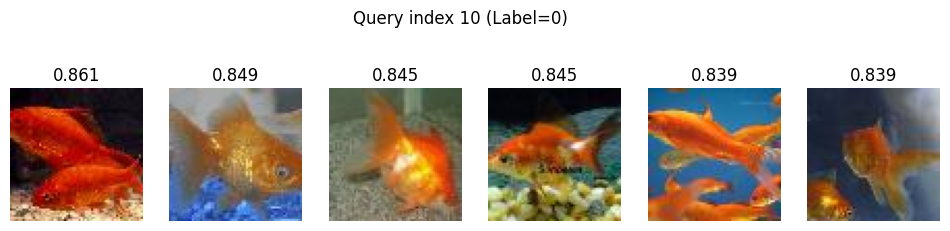

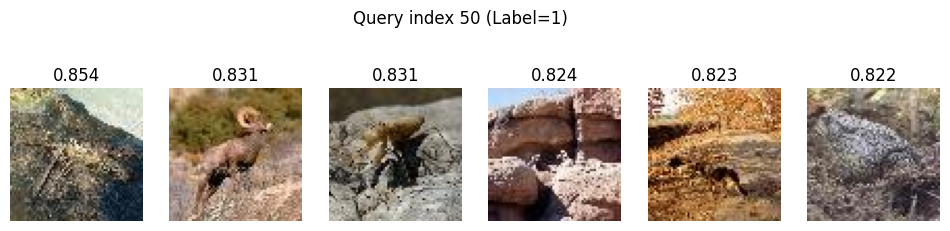

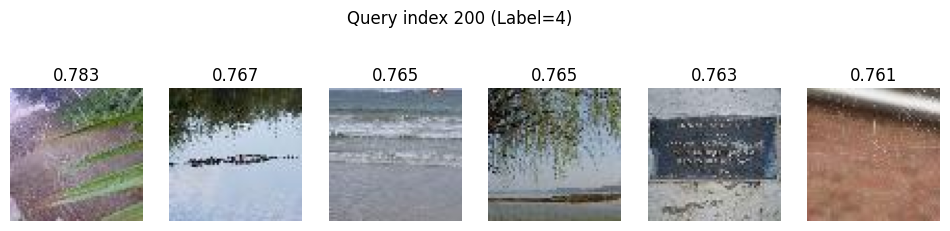

In [ ]:
import json, matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import numpy as np

# load correct paths file
with open('/content/drive/MyDrive/image_similarity_project/val_paths.json','r') as f:
    val_paths = json.load(f)

val_embs = np.load('val_embs.npy')
val_labels = np.load('val_labs.npy')

# choose queries to display
queries = [10, 50, 200]

for q_idx in queries:
    sims = cosine_similarity(val_embs[q_idx:q_idx+1], val_embs)[0]
    sims[q_idx] = -1e9
    topk = np.argsort(sims)[-6:][::-1]  # top 5 neighbors
    scores = sims[topk]

    plt.figure(figsize=(12,3))
    for i, idx in enumerate(topk):
        img = Image.open(val_paths[idx]).convert('RGB')
        plt.subplot(1,6,i+1)
        plt.imshow(img)
        plt.title(f'{scores[i]:.3f}')
        plt.axis('off')
    plt.suptitle(f'Query index {q_idx} (Label={val_labels[q_idx]})')
    plt.show()


In [ ]:
# Final retrieval metrics (robust)
import numpy as np, random
from sklearn.metrics.pairwise import cosine_similarity

val_embs = np.load('val_embs.npy')
val_labels = np.load('val_labs.npy')

def precision_at_k(query_idx, embs, labels, k=5):
    sims = cosine_similarity(embs[query_idx:query_idx+1], embs)[0]
    sims[query_idx] = -1e9
    topk = np.argsort(sims)[-k:][::-1]
    return (labels[topk] == labels[query_idx]).sum() / k

def average_precision_manual(query_idx, embs, labels):
    sims = cosine_similarity(embs[query_idx:query_idx+1], embs)[0]
    sims[query_idx] = -1e9
    order = np.argsort(sims)[::-1]
    relevance = (labels[order] == labels[query_idx]).astype(int)
    if relevance.sum() == 0: return 0.0
    cumrel = np.cumsum(relevance)
    ranks = np.arange(1, len(relevance)+1)
    prec_at_rel = cumrel[relevance==1] / ranks[relevance==1]
    return prec_at_rel.mean()

N = len(val_embs)
Q = 500 if N>500 else N
idxs = random.sample(range(N), Q)

p1 = np.mean([precision_at_k(i, val_embs, val_labels, k=1) for i in idxs])
p5 = np.mean([precision_at_k(i, val_embs, val_labels, k=5) for i in idxs])
p10 = np.mean([precision_at_k(i, val_embs, val_labels, k=10) for i in idxs])
map50 = np.mean([average_precision_manual(i, val_embs, val_labels) for i in idxs])

print(f'Precision@1: {p1:.4f}, @5: {p5:.4f}, @10: {p10:.4f}, mAP: {map50:.4f}')

# save metrics to Drive
import json, os
OUT="/content/drive/MyDrive/image_similarity_project"
os.makedirs(OUT, exist_ok=True)
metrics = {"Precision@1":float(p1),"Precision@5":float(p5),"Precision@10":float(p10),"mAP":float(map50)}
with open(f"{OUT}/retrieval_metrics.json","w") as f:
    json.dump(metrics,f,indent=2)
print("Saved metrics to", f"{OUT}/retrieval_metrics.json")


Precision@1: 0.4620, @5: 0.4296, @10: 0.3740, mAP: 0.1993
Saved metrics to /content/drive/MyDrive/image_similarity_project/retrieval_metrics.json


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


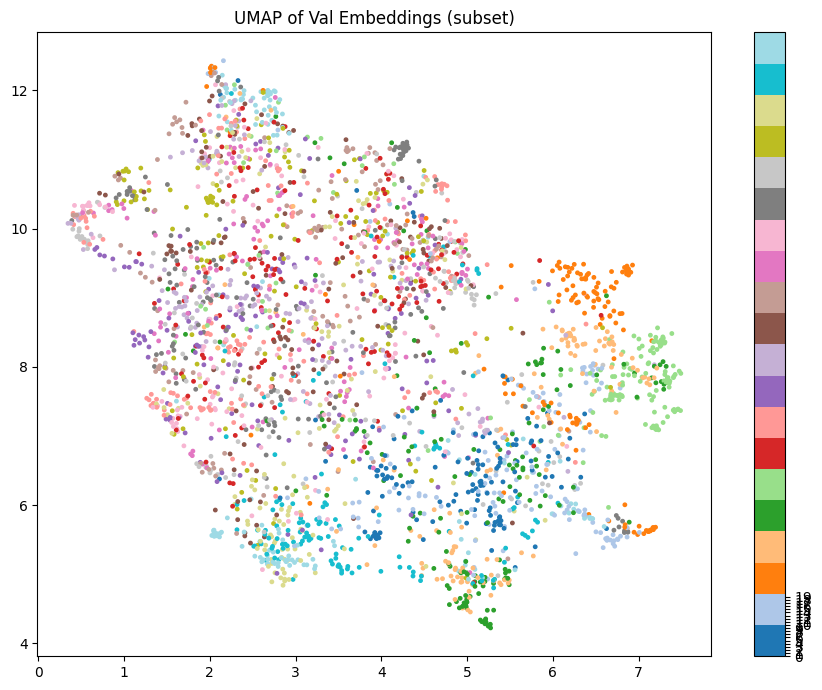

Saved UMAP to /content/drive/MyDrive/image_similarity_project/umap_val_embeddings.png


In [ ]:
# UMAP visualization (subset for speed)
import umap, matplotlib.pyplot as plt, numpy as np, os, random
OUT="/content/drive/MyDrive/image_similarity_project"
os.makedirs(OUT, exist_ok=True)

val_embs = np.load('val_embs.npy')
val_labels = np.load('val_labs.npy')

subset = 3000 if len(val_embs) > 3000 else len(val_embs)
idxs = random.sample(range(len(val_embs)), subset)
X = val_embs[idxs]
y = val_labels[idxs]

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
Z = reducer.fit_transform(X)

plt.figure(figsize=(9,7))
sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=6, cmap='tab20')
plt.title("UMAP of Val Embeddings (subset)")
plt.colorbar(sc, ticks=range(0,20))
plt.tight_layout()
plt.savefig(f"{OUT}/umap_val_embeddings.png", dpi=200)
plt.show()
print("Saved UMAP to", f"{OUT}/umap_val_embeddings.png")


In [ ]:
# Top-K (top-5) visual grids for 10 queries, saved to Drive
import json, numpy as np, os, random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

OUT="/content/drive/MyDrive/image_similarity_project/topk_grids"
os.makedirs(OUT, exist_ok=True)

with open('/content/drive/MyDrive/image_similarity_project/val_paths.json','r') as f:
    val_paths = json.load(f)

val_embs = np.load('val_embs.npy')
val_labels = np.load('val_labs.npy')

queries = random.sample(range(len(val_embs)), 10)  # 10 random queries
for q_idx in queries:
    sims = cosine_similarity(val_embs[q_idx:q_idx+1], val_embs)[0]
    sims[q_idx] = -1e9
    topk = np.argsort(sims)[-6:][::-1]  # top 5 neighbors
    scores = sims[topk]
    plt.figure(figsize=(14,3))
    for i, idx in enumerate(topk):
        img = Image.open(val_paths[idx]).convert('RGB')
        plt.subplot(1,6,i+1)
        plt.imshow(img)
        title = f"{scores[i]:.3f}" if i>0 else f"Query\n(lbl={val_labels[q_idx]})"
        plt.title(title, fontsize=9)
        plt.axis('off')
    fname = os.path.join(OUT, f"topk_query_{q_idx}.png")
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.close()
    print("Saved", fname)

print("All top-k grids saved to", OUT)


Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_3324.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_8521.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_7359.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_7024.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_4641.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_417.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_5962.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_8849.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_2329.png
Saved /content/drive/MyDrive/image_similarity_project/topk_grids/topk_query_3113.png
All top-k grids saved to /content/drive/MyDrive/image_similarity_project/topk_grids


In [ ]:
# Create a short results paragraph for your report
import json, os
OUT="/content/drive/MyDrive/image_similarity_project"
with open(f"{OUT}/retrieval_metrics.json",'r') as f:
    metrics = json.load(f)

train_acc = None
# if you saved val acc earlier as file, load it; else we include only retrieval metrics
blurb = f"""
Results summary:
- Dataset: Tiny ImageNet (train ≈100k, val =10k).
- Method: Pretrained ResNet50 embeddings (2048-D) + linear classifier trained on embeddings.
- Retrieval metrics (500 random queries): Precision@1 = {metrics['Precision@1']:.4f}, Precision@5 = {metrics['Precision@5']:.4f}, Precision@10 = {metrics['Precision@10']:.4f}, mAP = {metrics['mAP']:.4f}.
- A sample of top-k retrieval grids and a UMAP visualization of embeddings are saved alongside these results.
"""
with open(f"{OUT}/results_blurb.txt","w") as f:
    f.write(blurb.strip())
print("Saved results blurb to", f"{OUT}/results_blurb.txt")
print("\n" + blurb)


Saved results blurb to /content/drive/MyDrive/image_similarity_project/results_blurb.txt


Results summary:
- Dataset: Tiny ImageNet (train ≈100k, val =10k).
- Method: Pretrained ResNet50 embeddings (2048-D) + linear classifier trained on embeddings.
- Retrieval metrics (500 random queries): Precision@1 = 0.4620, Precision@5 = 0.4296, Precision@10 = 0.3740, mAP = 0.1993.
- A sample of top-k retrieval grids and a UMAP visualization of embeddings are saved alongside these results.



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Fig3.png to Fig3.png


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision import models

# Load pretrained ResNet50 backbone (same as training)
backbone = models.resnet50(pretrained=True)
backbone.fc = torch.nn.Identity()
backbone = backbone.cuda().eval()

# Preprocessing (same as val)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Load uploaded image
img_path = list(uploaded.keys())[0]   # automatically get the name of uploaded file
print("Using:", img_path)

img = Image.open(img_path).convert("RGB")
img_t = preprocess(img).unsqueeze(0).cuda()

# Extract embedding
with torch.no_grad():
    query_emb = backbone(img_t).cpu().numpy()   # shape (1, 2048)

print("Query embedding shape:", query_emb.shape)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using: Fig3.png
Query embedding shape: (1, 2048)


In [ ]:
# Load existing dataset embeddings
val_embs = np.load("val_embs.npy")
val_labels = np.load("val_labs.npy")

import json
with open('/content/drive/MyDrive/image_similarity_project/val_paths.json','r') as f:
    val_paths = json.load(f)


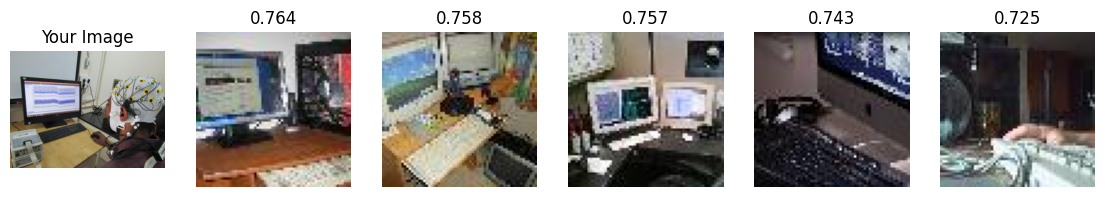

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Compute similarity to all TinyImageNet validation embeddings
sims = cosine_similarity(query_emb, val_embs)[0]

# Top 5 most similar images
topk = sims.argsort()[-5:][::-1]

plt.figure(figsize=(14,4))

# show your uploaded image first
plt.subplot(1,6,1)
plt.imshow(img)
plt.title("Your Image")
plt.axis("off")

# show retrieved images
for i, idx in enumerate(topk, start=2):
    sim_img = Image.open(val_paths[idx]).convert("RGB")
    plt.subplot(1,6,i)
    plt.imshow(sim_img)
    plt.title(f"{sims[idx]:.3f}")
    plt.axis("off")

plt.show()


In [ ]:
!pip install -q gradio pillow scikit-learn

import gradio as gr
import torch, numpy as np, json
from PIL import Image
from torchvision import transforms, models
from sklearn.metrics.pairwise import cosine_similarity
import os

# ------------------------------
# Load dataset embeddings & paths
# ------------------------------

VAL_PATHS_JSON = "/content/drive/MyDrive/image_similarity_project/val_paths.json"

val_embs = np.load("val_embs.npy")
val_labels = np.load("val_labs.npy")

with open(VAL_PATHS_JSON, "r") as f:
    val_paths = json.load(f)

# ------------------------------
# Load backbone (ResNet50)
# ------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = models.resnet50(pretrained=True)
backbone.fc = torch.nn.Identity()        # remove final classifier -> output embeddings
backbone = backbone.to(device).eval()

# Preprocessing transform (same as training/validation)
preproc = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ------------------------------
# Core search function
# ------------------------------

def search_image(uploaded_img, top_k=5):
    img = uploaded_img.convert("RGB")

    # preprocess
    x = preproc(img).unsqueeze(0).to(device)

    # extract embedding
    with torch.no_grad():
        q_emb = backbone(x).cpu().numpy()   # shape (1,2048)

    # cosine similarity with all TinyImageNet val embeddings
    sims = cosine_similarity(q_emb, val_embs)[0]

    # top-k most similar images
    topk_indices = sims.argsort()[-top_k:][::-1]

    # prepare results for Gradio gallery
    results = []
    display_size = (784, 784)             # size to display (use NEAREST to avoid blur)
    for idx in topk_indices:
        try:
            sim_img = Image.open(val_paths[idx]).convert("RGB")
            sim_img = sim_img.resize(display_size, resample=Image.NEAREST)
            results.append((sim_img, f"Similarity: {sims[idx]:.3f}"))
        except Exception as e:
            # if an image fails to load, skip it
            print(f"Warning: failed to open {val_paths[idx]} -> {e}")
            continue

    return img, results

# ------------------------------
# Gradio interface
# ------------------------------

title = "Image Similarity Search — ResNet50 Deep Embeddings"
description = """
Upload any image, and the system retrieves the most visually similar images
from the Tiny ImageNet dataset using deep learning embeddings + cosine similarity.
"""

iface = gr.Interface(
    fn=search_image,
    inputs=[
        gr.Image(type="pil", label="Upload an Image"),
        gr.Slider(1, 10, value=5, step=1, label="Top-K Results")
    ],
    outputs=[
        gr.Image(type="pil", label="Query Image"),
        gr.Gallery(label="Top-K Similar Images")
    ],
    title=title,
    description=description,
    allow_flagging="never"
)

# Start with public shareable link
iface.launch(share=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cf6587751228e5bb64.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
